In [ ]:
import numpy as np
from torchvision import datasets, transforms
import torch
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt



USE_CUDA = torch.cuda.is_available()
# USE_CUDA = False
DLD_DATA = True
print(USE_CUDA)

False


In [ ]:
params = {
    "mnistfc":{
        "eps": 0.03,
        "classes": list(range(10))
    }
}


In [ ]:
TRAIN_BS = 60000
TEST_BS = 10000

device = torch.device("cuda" if USE_CUDA else "cpu")
train_kwargs = {'batch_size': TRAIN_BS, 'shuffle': False}
test_kwargs = {'batch_size': TEST_BS, 'shuffle': False}
# if USE_CUDA:
#     cuda_kwargs = {'num_workers': 1,
#                    'pin_memory': True,
#                    'shuffle': True}
#     train_kwargs.update(cuda_kwargs)
#     test_kwargs.update(cuda_kwargs)
    
transform = transforms.Compose([
    transforms.ToTensor(),
])



train_set = datasets.MNIST('./data', train=True, download=DLD_DATA,
                          transform=transform)
test_set = datasets.MNIST('./data', train=False, download=DLD_DATA,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_set, **test_kwargs)

for train_data, train_target in train_loader:
    print(train_data.size())
    print(train_target.size())
    
for test_data, test_target in test_loader:
    print(test_data.size())
    print(test_target.size())
    
train_by_cls = {}
test_by_cls = {}

for picked_cls in range(10):
    train_cls_idx = train_target==picked_cls    

    sub_train_dataset = train_data[train_cls_idx].to(device)
    sub_train_targets = train_target[train_cls_idx].to(device)

    test_cls_idx = test_target==picked_cls

    sub_test_dataset = test_data[test_cls_idx].to(device)
    sub_test_targets = test_target[test_cls_idx].to(device)
    
#     print(sub_train_dataset.shape)
    
    train_by_cls[picked_cls] = {}
    train_by_cls[picked_cls]["data"] = sub_train_dataset
    train_by_cls[picked_cls]["targets"] = sub_train_targets
    
    test_by_cls[picked_cls] = {}
    test_by_cls[picked_cls]["data"] = sub_test_dataset
    test_by_cls[picked_cls]["targets"] = sub_test_targets
    
    print(f"Train: for class {picked_cls}, total = {len(sub_train_targets)}")
    print(f"Test: for class {picked_cls}, total = {len(sub_test_targets)}")
    print()



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])
Train: for class 0, total = 5923
Test: for class 0, total = 980

Train: for class 1, total = 6742
Test: for class 1, total = 1135

Train: for class 2, total = 5958
Test: for class 2, total = 1032

Train: for class 3, total = 6131
Test: for class 3, total = 1010

Train: for class 4, total = 5842
Test: for class 4, total = 982

Train: for class 5, total = 5421
Test: for class 5, total = 892

Train: for class 6, total = 5918
Test: for class 6, total = 958

Train: for class 7, total = 6265
Test: for class 7, total = 1028

Train: for class 8, total = 5851
Test: for class 8, total = 974

Train: for class 9, total = 5949
Test: for class 9, total = 1009



In [ ]:
csv_dirname = "mnist_csv"

if not os.path.isdir(csv_dirname):
    os.mkdir(csv_dirname)


csv_name = "mnist_L{}_cls{}.csv"
eps = 0.05
count_find = 0
for picked_cls in range(10):
    print(f"Calculating for class {picked_cls}")
    cls_train_data = train_by_cls[picked_cls]["data"]
    cls_test_data = test_by_cls[picked_cls]["data"]

    l1_pair_distance_df = pd.DataFrame()
    l2_pair_distance_df = pd.DataFrame()
    linf_pair_distance_df = pd.DataFrame()

    cls_train_data = cls_train_data.reshape(-1, 28, 28)
    cls_test_data = cls_test_data.reshape(-1, 28, 28)
    
    for test_idx in range(len(cls_test_data)):
        test_img = cls_test_data[test_idx]
        test_img_repeat = test_img.repeat(len(cls_train_data),1,1)
        
        diff = (cls_train_data - test_img_repeat).reshape(-1, 28*28)
        l_1 = torch.linalg.vector_norm(diff, ord=1, dim=-1 )
        l_2 = torch.linalg.vector_norm(diff, ord=2, dim=-1 )
        l_inf = torch.linalg.vector_norm(diff, ord=np.inf, dim=-1 )

        l1_df = pd.DataFrame(l_1.cpu().detach().numpy(), columns=[test_idx])
        l2_df = pd.DataFrame(l_2.cpu().detach().numpy(), columns=[test_idx])
        linf_df = pd.DataFrame(l_inf.cpu().detach().numpy(), columns=[test_idx])

        l1_pair_distance_df = pd.concat((l1_pair_distance_df, l1_df), axis=1)
        l2_pair_distance_df = pd.concat((l2_pair_distance_df, l2_df), axis=1)
        linf_pair_distance_df = pd.concat((linf_pair_distance_df, linf_df), axis=1)
    
        
        if l_inf.min().item() <= eps:
            print(f"Found example test from class {picked_cls} with idx={test_idx} for vector norm")
            count_find += 1

    l1_pair_distance_df.to_csv(os.path.join(csv_dirname, csv_name.format(1, picked_cls)))
    l2_pair_distance_df.to_csv(os.path.join(csv_dirname, csv_name.format(2, picked_cls)))   
    linf_pair_distance_df.to_csv(os.path.join(csv_dirname, csv_name.format("inf", picked_cls)))   
    
print(f"Totally found {count_find} for eps={eps}")

extension_zip = ".zip"

zip_file = csv_dirname + extension_zip
!zip -r $zip_file $csv_dirname

# from google.colab import files
# files.download(zip_file)

Calculating for class 0
Calculating for class 1
Calculating for class 2
Calculating for class 3
Calculating for class 4
Calculating for class 5
Calculating for class 6
Calculating for class 7
Calculating for class 8
Calculating for class 9
Totally found 0 for eps=0.05


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


<Figure size 432x288 with 0 Axes>

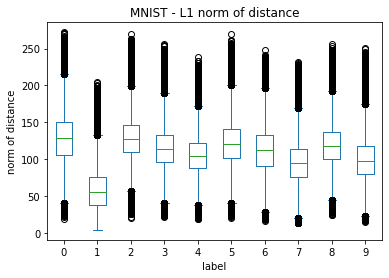

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


<Figure size 432x288 with 0 Axes>

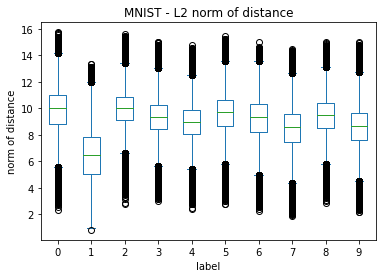

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


<Figure size 432x288 with 0 Axes>

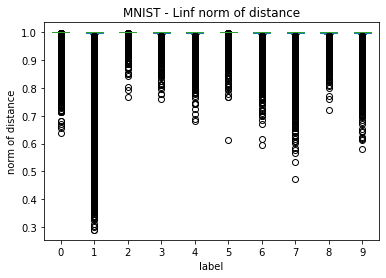

In [ ]:
csv_dirname = "mnist_csv"


csv_name = "mnist_L{}_cls{}.csv"

norms = [1, 2, 'inf']

img_name =  "mnist_L{}.png"
for norm in norms:
    all_cls_df = pd.DataFrame()
    for cls in range(10):
        filename = csv_name.format(norm, cls)

        df = pd.read_csv(os.path.join(csv_dirname, filename), index_col=[0])
        # df.plot(kind="box")
        # plt.show()
        # print(df.index, df.columns)
        all_values = df.to_numpy().flatten()
        all_values_df = pd.DataFrame(data=all_values, columns=[cls])
        all_cls_df = pd.concat((all_cls_df, all_values_df), axis=1)
    f = plt.figure()
    all_cls_df.plot(kind="box",showfliers=True)
    plt.xlabel("label")
    plt.ylabel("norm of distance")
    plt.title(f"MNIST - L{norm} norm of distance")
    plt.savefig(img_name.format(norm))
    plt.show()
    plt.close(f)
    

    
